In [220]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import skimage as ski
from skimage.measure import label
from skimage.color import label2rgb
import cv2 as cv2

In [221]:
# read in our original image as grayscale
img = cv2.imread("tafel/Tf001.jpg", cv2.IMREAD_GRAYSCALE)

# bilateral filter
blur = cv2.bilateralFilter(img, 1, 100, 100)

# threshold
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# invert the image using bitwise_not
inverted_image = cv2.bitwise_not(thresh)

# skeletonize
skeleton = skeletonize(inverted_image)


In [222]:
plt.figure(figsize=(200,125))
plt.imshow(skeleton)

In [262]:
import numpy as np
from skimage.io import imread
from skimage.filters import threshold_local
from skimage.morphology import label, dilation, disk, convex_hull_image
from skimage.measure import regionprops
from scipy.spatial.distance import cdist

def extract_leaf_masks_with_convex_hulls(image_path, landmarks, min_area=500):
    """
    Extracts mutually exclusive convex hull masks for leaves in a venation image.

    Args:
        image_path (str): Path to the venation image.
        landmarks (list of (x, y)): Coordinates for each leaf (ideally near center).
        min_area (int): Minimum area to consider a region as a leaf.

    Returns:
        List of binary masks (boolean numpy arrays), one per leaf, with convex hulls.
    """
    # Load grayscale image
    image = imread(image_path, as_gray=True)

    # Liberal adaptive thresholding
    block_size = 35
    offset = 15
    adaptive_thresh = threshold_local(image, block_size, offset=offset)
    binary = image < adaptive_thresh

    # Aggressive dilation to unify weakly connected venation
    binary = dilation(binary, disk(5))

    # Label connected components
    labeled = label(binary)
    props = regionprops(labeled)

    # Filter regions and store hulls + centroids
    hulls = []
    centroids = []
    for prop in props:
        if prop.area >= min_area:
            region_mask = labeled == prop.label
            hull = convex_hull_image(region_mask)
            hulls.append(hull)
            centroids.append(prop.centroid[::-1])  # (x, y)

    centroids = np.array(centroids)
    landmarks = np.array(landmarks)

    # Match each landmark to closest hull by centroid
    distances = cdist(landmarks, centroids)
    assignment = np.argmin(distances, axis=1)

    # Ensure unique assignment
    unique_indices = set()
    masks = []
    for i in range(len(landmarks)):
        idx = assignment[i]
        if idx in unique_indices:
            continue  # skip duplicate matches
        unique_indices.add(idx)
        masks.append(hulls[idx])

    # Make masks mutually exclusive
    exclusive = np.zeros_like(masks[0], dtype=int)
    for i, mask in enumerate(masks, 1):
        exclusive[(mask) & (exclusive == 0)] = i

    # Return mutually exclusive masks
    final_masks = [(exclusive == i) for i in range(1, len(masks) + 1)]
    return final_masks


In [263]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb
from skimage.io import imread
from skimage.morphology import convex_hull_image

def visualize_convex_hulls_on_image(image_path, raw_masks, landmarks=None, show_partial=False):
    """
    Visualizes convex hulls (and optionally partial masks) on the original image.

    Args:
        image_path (str): Path to image.
        raw_masks (list of bool arrays): Original segmented leaf masks.
        landmarks (list of (x, y), optional): Landmark coordinates.
        show_partial (bool): If True, overlay original partial masks as an outline.
    """
    image = imread(image_path)
    if image.ndim == 3:
        base = image.copy()
    else:
        base = np.stack([image] * 3, axis=-1)

    # Compute convex hulls
    hulls = [convex_hull_image(mask) for mask in raw_masks]

    # Make label image of hulls
    combined = np.zeros(hulls[0].shape, dtype=int)
    for i, hull in enumerate(hulls, 1):
        combined[hull] = i

    # Overlay convex hulls in color
    overlay = label2rgb(combined, image=base, bg_label=0, alpha=0.4)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title("Convex Hulls Overlaid on Original Image")
    plt.axis("off")

    # Optionally plot outlines of the raw (partial) masks
    if show_partial:
        for i, mask in enumerate(raw_masks):
            contours = np.argwhere(mask)
            if len(contours) > 0:
                y, x = zip(*contours)
                plt.scatter(x, y, s=0.1, color='black', alpha=0.2, label='Partial Segments' if i == 0 else "")

    # Plot landmarks if given
    if landmarks:
        landmarks = np.array(landmarks)
        plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', marker='x', label='Landmarks')

    if show_partial or landmarks:
        plt.legend()
    plt.show()


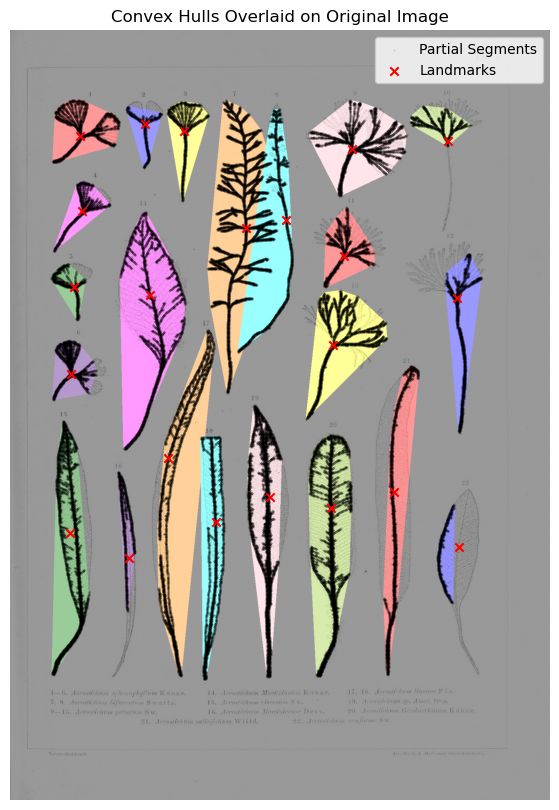

In [264]:
landmarks = np.loadtxt("./L001.txt")
landmark_tuples = [tuple(row) for row in landmarks]

masks = extract_leaf_masks("./modTf001.tif", landmark_tuples)

# Visualize first few masks
visualize_convex_hulls_on_image("./modTf001.tif", masks, landmark_tuples, show_partial=True)


In [202]:
# read in our original image as grayscale
img = cv2.imread("example3.jpg", cv2.IMREAD_GRAYSCALE)

# choose the minimum axis size in pixels
minimum_axis = 100

if min(img.shape[0],img.shape[1]) < minimum_axis:

    
    newsize = 1000
    minsize = min(img.shape[0],img.shape[1])
    scale_prop = newsize/minsize

    # calculate new heights and widths
    width = int(img.shape[1] * scale_prop )
    height = int(img.shape[0] * scale_prop )
    dsize = (width, height)

    # resize the image
    img = cv2.resize(img, dsize)

# choose a blur

# gaussian blur
#gblur = cv2.GaussianBlur(img_resize,(5,5),50)

# median filter
#mblur = cv2.medianBlur(gblur,5)

# bilateral filter
blur = cv2.bilateralFilter(img,1,75,75)

# threshold
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


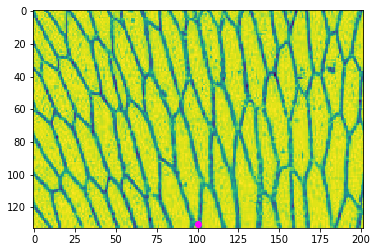

In [206]:
# define the end point to calculate paths

xend = 100
yend = 130

plt.imshow(img)
plt.scatter(xend,yend, c="magenta") # end

end = np.array([yend,xend])

In [207]:
xval_paths = []
yval_paths = []
cost_vals = []
    

for i in range(thresh.shape[0]):
    
    if i%20==0:
        print(i)

    for j in range(thresh.shape[1]):
        
        if thresh[i][j] == 0:
            
            start = np.array([i,j])
            
            path, cost = route_through_array(thresh, start, end)
            ypath, xpath = zip(*path)
            xval_paths.append(xpath)
            yval_paths.append(ypath)
            cost_vals.append(cost)


0
20
40
60
80
100
120


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500


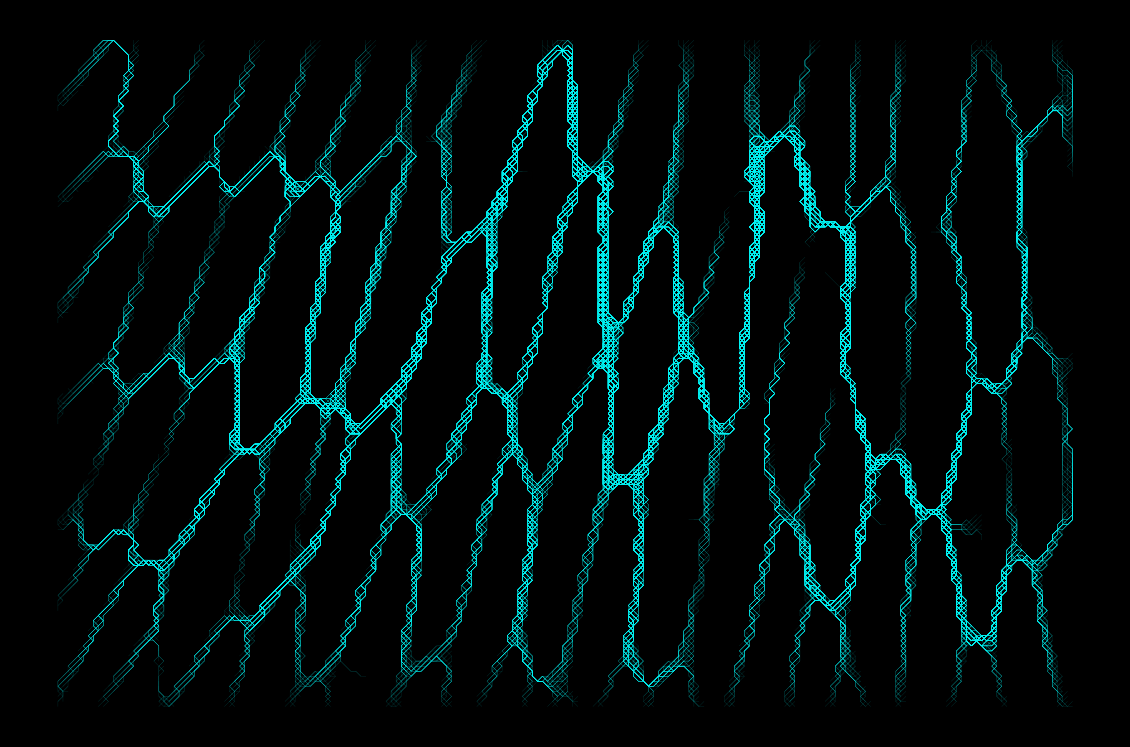

In [208]:
fc = "black"
pc = "cyan"

plt.figure(figsize=(20,20),facecolor=fc)

for p in range(len(xval_paths)):
    
    if p%500==0:
        print(p)
        
    plt.plot(xval_paths[p],yval_paths[p],c=pc,lw=0.3,alpha=0.25)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis("off")
    
plt.savefig('test3.jpg', facecolor=fc, edgecolor='none')

